## 1. Introdução

In [3]:
# ======= Importando bibliotecas ======= #
# gerais
import pandas as pd

# NLP, deep learning
import torch
import torch.nn as nn
from sklearn.manifold import TSNE
from sklearn.preprocessing import normalize
from sentence_transformers import SentenceTransformer
from classes.Transformador import Transformador

# visualização
import matplotlib.pyplot as plt
from tqdm import tqdm # This will make a progress bar for us
import plotly.express as px

### 1.1 Dataset

In [4]:
# Carregar o dataset e modelo
df = pd.read_csv('data/arxiv3.csv')

df = df.drop(columns=['Unnamed: 0', 'update_date'])

df.head()

title  \
0  Bosonic characters of atomic Cooper pairs acro...   
1  Measurement of the Hadronic Form Factor in D0 ...   
2  Spectroscopic Properties of Polarons in Strong...   
3  Tuning correlation effects with electron-phono...   
4  Convergence of the discrete dipole approximati...   

                                             authors  \
0                           Y. H. Pong and C. K. Law   
1          The BABAR Collaboration, B. Aubert, et al   
2  A. S. Mishchenko (1 and 2) and N. Nagaosa (1 a...   
3                       J.P.Hague and N.d'Ambrumenil   
4  Maxim A. Yurkin, Valeri P. Maltsev, Alfons G. ...   

                                            abstract  \
0    We study the two-particle wave function of p...   
1    The shape of the hadronic form factor f+(q2)...   
2    We present recent advances in understanding ...   
3    We investigate the effect of tuning the phon...   
4    We performed a rigorous theoretical converge...   

                           categories  
0                   cond-mat.mes-hall  
1                              hep-ex  
2  cond-mat.str-el cond-mat.stat-mech  
3                     cond-mat.str-el  
4      physics.optics physics.comp-ph

### 1.2 Embeddings

In [5]:
# Carregando o modelo pré-treinado de gerar embeddings 
model = SentenceTransformer("all-MiniLM-L6-v2")

Criação dos embeddings a partir do modelo

In [6]:
## Pegando os resumos dos artigos
# sentences = df['abstract'].values

## Transformando os resumos em embeddings
# embeddings = model.encode(sentences)
# print(embeddings.shape)

## Salvando os embeddings
# torch.save(embeddings, 'model_embedding/embeddings_bert.pt')

In [7]:
# Carregando os embeddings
embeddings = torch.load('model_embedding/embeddings_bert.pt')
tensor_embeddings = torch.tensor(embeddings)

C:\Users\livia\AppData\Local\Temp\ipykernel_34540\145323403.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  embeddings = torch.load('model_embedding/embeddings_bert.pt')

### 1.3 Treinamento

100%|██████████| 150/150 [00:27<00:00,  5.48it/s]


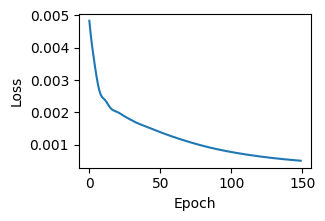

In [26]:

transformador = Transformador(
    n_inputs=384,
    n_hidden=200
)

optimizer = torch.optim.Adam(transformador.parameters(), lr=1e-3) 

criterion = nn.MSELoss()

losses = []
for epoch in tqdm(range(150)):


    optimizer.zero_grad()
    output, _ = transformador(tensor_embeddings)
    
    loss = criterion(output, tensor_embeddings)

    loss.backward()
    optimizer.step()
    losses.append(loss.item())

plt.figure(figsize=(3,2))
plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show() 

In [27]:
X = df['abstract'].values
 

with torch.no_grad():
    X_tensor = tensor_embeddings.clone().detach()
    _, X_tuned = transformador(X_tensor)

In [32]:
# Salvando modelo
torch.save(model.state_dict(), 'model_embedding/modelo.pth')

# Salvando transformador
torch.save(transformador.state_dict(), 'model_embedding/transformador.pth')

# Salvando embeddings transformados
torch.save(X_tuned, 'model_embedding/embeddings_transformados.pt')

## 2.1 Visualização

In [11]:
def get_cluster(matrix ):
    X_viz = matrix.detach().numpy()
    tsne = TSNE(n_components=2, perplexity=30)
    X_proj = tsne.fit_transform(X_viz)

    px.defaults.width = 1500
    px.defaults.height = 1000

    df_viz = pd.DataFrame(X_proj, columns=['x', 'y'])
    df_viz['title'] = df['title']
    df_viz['abstract'] = df['abstract']

    # df_viz['category'] = df['categories']


    fig = px.scatter(df_viz, x='x', y='y',   hover_data=['title'])
    fig.update_traces(textposition='top center')
    
    return fig, df_viz



### 2.1 Pré-treinamento

In [ ]:
fig1, df_viz1 = get_cluster(tensor_embeddings)

In [ ]:
fig1.update_layout(title='Cluster de embeddings pré-treinados')
fig1.update_traces(marker=dict(color='red'))
fig1.show()

### 2.2 Pós-treinamento

In [ ]:
fig2, df_viz2 = get_cluster(X_tuned)

In [ ]:
fig2.update_layout(
    title='Cluster de embeddings treinados',
    )

fig2.show()

## 3. Sistema de busca

In [28]:
class Finder():
    def __init__(self, df, embeddings_matrix, model, transformador, tuned_matrix):
        self.df = df
        self.embeddings_matrix = embeddings_matrix
        self.tuned_matrix = tuned_matrix
        self.model = model
        self.transformador = transformador

    def predict_query(self, query, tuned=False, limit=0.5):
        query_processed = self.model.encode([query])

        if tuned:
            query_processed = self.transformador(torch.tensor(query_processed))[1].detach().numpy()
            embeddings_matrix_ = normalize(self.tuned_matrix)
        else:
            embeddings_matrix_ = normalize(self.embeddings_matrix)

        query_processed_ = normalize(query_processed.reshape(1, -1))




        R = embeddings_matrix_ @ query_processed_.T

        df_ = self.df.copy()
        relevance = R.flatten()
        df_["relevance"] = relevance

        df_filtered = df_[relevance > limit]
        df_final = df_filtered.sort_values("relevance", ascending=False)

        # Selecionar colunas de interesse
        df_final = df_final[['title', 'abstract', 'relevance']]

        # print the top 10 abstracts
        tam = min(10, len(df_final))
        for i in range(tam):
            print(df_final['abstract'].iloc[i])
            print('-----------------------------------')
            
        return df_final.head(10)


finder = Finder(df, embeddings, model, transformador, X_tuned )


### Testes com os embeddings pós-treinamento

In [33]:
finder.predict_query('neural network', True, 0.7)

  An associative memory model and a neural network model with a Mexican-hat
type interaction are the two most typical attractor networks used in the
artificial neural network models. The associative memory model has discretely
distributed fixed-point attractors, and achieves a discrete information
representation. On the other hand, a neural network model with a Mexican-hat
type interaction uses a line attractor to achieves a continuous information
representation, which can be seen in the working memory in the prefrontal
cortex and columnar activity in the visual cortex. In the present study, we
propose a neural network model that achieves discrete and continuous
information representation. We use a statistical-mechanical analysis to find
that a localized retrieval phase exists in the proposed model, where the memory
pattern is retrieved in the localized subpopulation of the network. In the
localized retrieval phase, the discrete and continuous information
representation is achieved by 

title  \
9979   Neural network model with discrete and continu...   
5521   Learning of correlated patterns by simple perc...   
16765  Theory and modeling of the magnetic field meas...   
7466   A Growing Self-Organizing Network for Reconstr...   
227                            A balanced memory network   
12539  Modeling Connectivity in Terms of Network Acti...   
16033  Galaxy Zoo: Reproducing Galaxy Morphologies Vi...   
3732   Optimal network topologies for information tra...   
2939   Dynamics of Neural Networks with Continuous At...   
194    Period-two cycles in a feed-forward layered ne...   

                                                abstract  relevance  
9979     An associative memory model and a neural net...   0.808772  
5521     Learning behavior of simple perceptrons is a...   0.804218  
16765    The magnetic diagnostics subsystem of the LI...   0.797617  
7466     Self-organizing networks such as Neural Gas,...   0.786276  
227      A fundamental problem in neuroscience is und...   0.780160  
12539    A new complex network model is proposed whic...   0.777826  
16033    We present morphological classifications obt...   0.776197  
3732     This work clarifies the relation between net...   0.773260  
2939     We investigate the dynamics of continuous at...   0.769132  
194      The effects of dominant sequential interacti...   0.768802

In [34]:
finder.predict_query("database", True, 0.7)

  ATLAS event data processing requires access to non-event data (detector
conditions, calibrations, etc.) stored in relational databases. The
database-resident data are crucial for the event data reconstruction processing
steps and often required for user analysis. A main focus of ATLAS database
operations is on the worldwide distribution of the Conditions DB data, which
are necessary for every ATLAS data processing job. Since Conditions DB access
is critical for operations with real data, we have developed the system where a
different technology can be used as a redundant backup. Redundant database
operations infrastructure fully satisfies the requirements of ATLAS
reprocessing, which has been proven on a scale of one billion database queries
during two reprocessing campaigns of 0.5 PB of single-beam and cosmics data on
the Grid. To collect experience and provide input for a best choice of
technologies, several promising options for efficient database access in user
analysis were eval

title  \
18230  Scalable Database Access Technologies for ATLA...   
4919   A Logical Model and Data Placement Strategies ...   
6073   Virtual Observatory activities in the AMIGA group   
10774  An exploration of CUDA and CBEA for a gravitat...   
1673         VEGAS, the VERITAS Gamma-ray Analysis Suite   
12433  The Science Vision for the Stratospheric Obser...   
13781  EURONEAR - Data Mining of Asteroids and Near E...   

                                                abstract  relevance  
18230    ATLAS event data processing requires access ...   0.761008  
4919     MEMS storage devices are new non-volatile se...   0.733986  
6073     The AMIGA project (Analysis of the interstel...   0.730323  
10774    We present a detailed approach for making us...   0.722506  
1673     VERITAS, the Very Energetic Radiation Imagin...   0.703462  
12433    An updated Science Vision for the SOFIA proj...   0.703334  
13781    Besides new observations, mining old photogr...   0.700148

In [ ]:
finder.predict_query('wolf', True, 0.7)

  We present the main results of the PhD Thesis carried out by
L\'opez-S\'anchez (2006), in which a detailed morphological, photometrical and
spectroscopical analysis of a sample of 20 Wolf-Rayet (WR) galaxies was
realized. The main aims are the study of the star formation and O and WR
stellar populations in these galaxies and the role that interactions between
low surface companion objects have in the triggering of the bursts. We analyze
the morphology, stellar populations, physical conditions, chemical abundances
and kinematics of the ionized gas, as well as the star-formation activity of
each system.

-----------------------------------
  We have constructed a new code to produce synthetic spectra of stellar
populations that includes massive binaries. We have tested this code against
the broadband colours of unresolved young massive stellar clusters in nearby
galaxies, the equivalent widths of the Red and Blue Wolf-Rayet bumps in
star-forming SDSS galaxies and the UV and optical spe

title  \
217    Interactions and star formation activity in Wo...   
15826      Spectral synthesis including massive binaries   
14017  First bounds on the VHE gamma-ray emission fro...   
9730   On the massive star content of the nearby dwar...   
20000  X-ray emission characteristics of two WR binar...   
6973   JaxoDraw: A graphical user interface for drawi...   
4286                       Bohr's atomic model revisited   
11908  A Near-Infrared Survey of the Inner Galactic P...   
16928  Discovery of a new Wolf-Rayet star and its rin...   
14893  Spectral classification of the mass donors in ...   

                                                abstract  relevance  
217      We present the main results of the PhD Thesi...   0.743514  
15826    We have constructed a new code to produce sy...   0.733612  
14017    Different theoretical models predict VHE gam...   0.722106  
9730     Aims: We investigate the massive stellar con...   0.721294  
20000    We present X-ray analysis of two Wolf-Rayet ...   0.717229  
6973     A new version of the Feynman graph plotting ...   0.715278  
4286     Bohr's atomic model, its relationship to the...   0.712821  
11908    The discovery of new Wolf-Rayet (WR) stars i...   0.708331  
16928    We report the serendipitous discovery of a r...   0.708007  
14893    We report near-infrared observations of the ...   0.707757

### Testes com embeddings pré-treinamento

In [35]:
finder.predict_query("neural network", tuned=False, limit=0.35)


  The magnetic diagnostics subsystem of the LISA Technology Package (LTP) on
board the LISA PathFinder (LPF) spacecraft includes a set of four tri-axial
fluxgate magnetometers, intended to measure with high precision the magnetic
field at their respective positions. However, their readouts do not provide a
direct measurement of the magnetic field at the positions of the test masses,
and hence an interpolation method must be designed and implemented to obtain
the values of the magnetic field at these positions. However, such
interpolation process faces serious difficulties. Indeed, the size of the
interpolation region is excessive for a linear interpolation to be reliable
while, on the other hand, the number of magnetometer channels does not provide
sufficient data to go beyond the linear approximation. We describe an
alternative method to address this issue, by means of neural network
algorithms. The key point in this approach is the ability of neural networks to
learn from suitable tr

title  \
16765  Theory and modeling of the magnetic field meas...   
6518   New approach to the Parton Distribution Functi...   
194    Period-two cycles in a feed-forward layered ne...   
7466   A Growing Self-Organizing Network for Reconstr...   
9979   Neural network model with discrete and continu...   
14730  Neural Modeling and Control of Diesel Engine w...   
12628  A "Cellular Neuronal" Approach to Optimization...   
9018   An hierarchical artificial neural network syst...   
5521   Learning of correlated patterns by simple perc...   
577    Structural Health Monitoring Using Neural Netw...   

                                                abstract  relevance  
16765    The magnetic diagnostics subsystem of the LI...   0.453817  
6518     We propose a Parton Distribution Function (P...   0.437594  
194      The effects of dominant sequential interacti...   0.429362  
7466     Self-organizing networks such as Neural Gas,...   0.429197  
9979     An associative memory model and a neural net...   0.429100  
14730    The paper describes a neural approach for mo...   0.428894  
12628    The Hopfield-Tank (1985) recurrent neural ne...   0.423678  
9018     This work presents a simple artificial neura...   0.413035  
5521     Learning behavior of simple perceptrons is a...   0.411542  
577      Composite fabrication technologies now provi...   0.407169

In [36]:
finder.predict_query("database", tuned=False, limit=0.35)


  ATLAS event data processing requires access to non-event data (detector
conditions, calibrations, etc.) stored in relational databases. The
database-resident data are crucial for the event data reconstruction processing
steps and often required for user analysis. A main focus of ATLAS database
operations is on the worldwide distribution of the Conditions DB data, which
are necessary for every ATLAS data processing job. Since Conditions DB access
is critical for operations with real data, we have developed the system where a
different technology can be used as a redundant backup. Redundant database
operations infrastructure fully satisfies the requirements of ATLAS
reprocessing, which has been proven on a scale of one billion database queries
during two reprocessing campaigns of 0.5 PB of single-beam and cosmics data on
the Grid. To collect experience and provide input for a best choice of
technologies, several promising options for efficient database access in user
analysis were eval

title  \
18230  Scalable Database Access Technologies for ATLA...   
6073   Virtual Observatory activities in the AMIGA group   
4919   A Logical Model and Data Placement Strategies ...   

                                                abstract  relevance  
18230    ATLAS event data processing requires access ...   0.493268  
6073     The AMIGA project (Analysis of the interstel...   0.393768  
4919     MEMS storage devices are new non-volatile se...   0.375099

In [37]:
finder.predict_query("wolf", tuned=False, limit=0.35)


  We present the main results of the PhD Thesis carried out by
L\'opez-S\'anchez (2006), in which a detailed morphological, photometrical and
spectroscopical analysis of a sample of 20 Wolf-Rayet (WR) galaxies was
realized. The main aims are the study of the star formation and O and WR
stellar populations in these galaxies and the role that interactions between
low surface companion objects have in the triggering of the bursts. We analyze
the morphology, stellar populations, physical conditions, chemical abundances
and kinematics of the ionized gas, as well as the star-formation activity of
each system.

-----------------------------------


title  \
217  Interactions and star formation activity in Wo...   

                                              abstract  relevance  
217    We present the main results of the PhD Thesi...   0.364229

## 4. Validação

### Testes de uso

In [38]:
finder.predict_query("Retrieval-Augmented Generation", tuned=False, limit=0.35)


  Huge amount of information is present in the World Wide Web and a large
amount is being added to it frequently. A query-specific summary of multiple
documents is very helpful to the user in this context. Currently, few systems
have been proposed for query-specific, extractive multi-document summarization.
If a summary is available for a set of documents on a given query and if a new
document is added to the corpus, generating an updated summary from the scratch
is time consuming and many a times it is not practical/possible. In this paper
we propose a solution to this problem. This is especially useful in a scenario
where the source documents are not accessible. We cleverly embed the sentences
of the current summary into the new document and then perform query-specific
summary generation on that document. Our experimental results show that the
performance of the proposed approach is good in terms of both quality and
efficiency.

-----------------------------------
  An associative me

title  \
14881             USUM: Update Summary Generation System   
9979   Neural network model with discrete and continu...   

                                                abstract  relevance  
14881    Huge amount of information is present in the...   0.418521  
9979     An associative memory model and a neural net...   0.373304

In [39]:
finder.predict_query("multicloud computing for enterprise", tuned=False, limit=0.35)

  This keynote paper: presents a 21st century vision of computing; identifies
various computing paradigms promising to deliver the vision of computing
utilities; defines Cloud computing and provides the architecture for creating
market-oriented Clouds by leveraging technologies such as VMs; provides
thoughts on market-based resource management strategies that encompass both
customer-driven service management and computational risk management to sustain
SLA-oriented resource allocation; presents some representative Cloud platforms
especially those developed in industries along with our current work towards
realising market-oriented resource allocation of Clouds by leveraging the 3rd
generation Aneka enterprise Grid technology; reveals our early thoughts on
interconnecting Clouds for dynamically creating an atmospheric computing
environment along with pointers to future community research; and concludes
with the need for convergence of competing IT paradigms for delivering our 21st
centu

title  \
5285   Market-Oriented Cloud Computing: Vision, Hype,...   
18659  Cloudbus Toolkit for Market-Oriented Cloud Com...   
14506                          Community Cloud Computing   
7754   Cloud Computing and Grid Computing 360-Degree ...   
18660  High-Performance Cloud Computing: A View of Sc...   
5283   Accelerating Large-scale Data Exploration thro...   
4720   Archer: A Community Distributed Computing Infr...   
19300  SPECI, a simulation tool exploring cloud-scale...   
10186  Using Dedicated and Opportunistic Networks in ...   
1778   Polish grid infrastructure for science and res...   

                                                abstract  relevance  
5285     This keynote paper: presents a 21st century ...   0.608860  
18659    This keynote paper: (1) presents the 21st ce...   0.608359  
14506    Cloud Computing is rising fast, with its dat...   0.596103  
7754     Cloud Computing has become another buzzword ...   0.560581  
18660    Scientific computing often requires the avai...   0.555655  
5283     Data-intensive applications often require ex...   0.450403  
4720     This paper introduces Archer, a community-ba...   0.444889  
19300    There is a rapid increase in the size of dat...   0.443585  
10186    This paper presents a case for exploiting th...   0.421219  
1778     Structure, functionality, parameters and org...   0.396711